# wine data


# import package

In [14]:
# import package
# warning
import warnings
warnings.filterwarnings("ignore")
# data
import numpy as np
import pandas as pd
# visulaize
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
# adjust data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# ML
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
# PCA
from sklearn.decomposition import PCA
# evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report, ConfusionMatrixDisplay


# import function

In [2]:
# import ML_func.py
from ML_func import ml_func
func = ml_func()

# import data

In [3]:
# import data
data = pd.read_excel("wine.xlsx")
data.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


# process data

In [5]:
# take out X, y
X = data.drop(columns=['Customer_Segment'])
y = data['Customer_Segment']

## original data

In [9]:
# original data
X_train_original, X_test_original, y_train, y_test = func.preprocess_data(
    X, y, 65536)

training data : 142
testing data : 36


## standardize data

In [10]:
# standardize data
X_train_scaled, X_test_scaled, y_train, y_test = func.preprocess_data(
    X, y, 65536, standard="True")

standardlize training data : 142
standardlize testing data : 36


## pca data

standardlize training data : 142
standardlize testing data : 36
finish doing pca


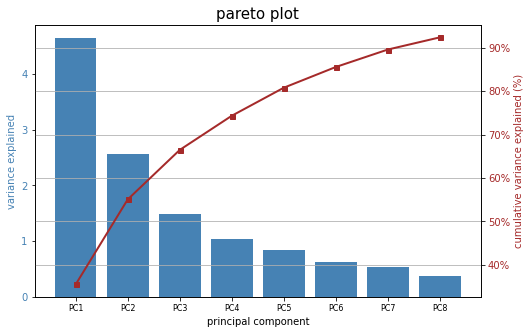

In [11]:
# pca data
X_train_pca, X_test_pca, y_train, y_test = func.preprocess_data(
    X, y, 65536, standard="True", pca="True", n_pc=0.9, show_plot="True")

上述得到的檔案共有 3 個，分別是以下 :  <br>
* 原始的資料 (original) <br>
* 標準化後的資料 (scaled) <br>
* 先標準化過後，再進行 PCA 的資料，取累積解釋力到 0.9 的 (pca) <br>

之後藉由這些資料各自拆分成不同的 train & test <br>
共得到 3 種類型的資料 <br>

# modeling standardize data
把標準化後的資料建模 <br>

## MLR
多元羅吉斯回歸 (Multinomial Logistic Regression) <br>
建模之後以 測試集 進行評估 <br>
並且列出 4 種指標以供觀察 <br>

### default

In [31]:
# MLR model & hyperparametersmodel
mlr_opts = dict(multi_class='auto', tol=1e-7, max_iter=int(1e6), verbose=1)
mlr_model = LogisticRegression(**mlr_opts)
mlr_model.fit(X_train_scaled, y_train)
# predict
y_pred_mlr = mlr_model.predict(X_test_scaled)

In [32]:
# evaluation
mlr_eva = func.evaluate_model(y_test, y_pred_mlr)
# change to df
mlr_df = pd.DataFrame(list(mlr_eva.items()), columns=[
                      ["standard", "standard"], ["MLR", "MLR"], ['metric', 'value']])
mlr_df

standard      
         MLR      
      metric value
0   accuracy  0.94
1  precision  0.95
2     recall  0.94
3   F1-score  0.94

### grid search

In [33]:
# search best parameter
param_grid = {
    'C': [0.008, 0.01, 0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l1', 'l2']
}

# model
mlr_opts = dict(multi_class='auto', tol=1e-6, max_iter=int(1e6), verbose=1)
mlr_model = LogisticRegression(**mlr_opts)

# grid search
grid_search = GridSearchCV(mlr_model, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# print
print("Best parameters found: ", grid_search.best_params_)

# predict
best_model = grid_search.best_estimator_
y_pred_mlr_best = best_model.predict(X_test_scaled)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'C': 0.008, 'penalty': 'l2', 'solver': 'newton-cg'}


In [34]:
# evaluation
mlr_eva_best = func.evaluate_model(y_test, y_pred_mlr_best)
# change to df
mlr_df_best = pd.DataFrame(list(mlr_eva_best.items()), columns=[
                      ["standard", "standard"], ["MLR", "MLR"], ['metric', 'value']])
mlr_df_best

standard      
         MLR      
      metric value
0   accuracy  0.92
1  precision  0.93
2     recall  0.92
3   F1-score  0.92

### MLR conclusion
可以發現 default 的結果就已經是最好的 <br>
因此使用 default 為最佳模型 <br>

## SVM
支援向量機 (Support Vector Machine) <br>
建模之後以 測試集 進行評估 <br>
並且列出 4 種指標以供觀察 <br>

### default

In [41]:
# SVM model & hyperparameter
svm_opts = dict(C=1, tol=1e-6, max_iter=int(1e6))
svm_model = SVC(kernel='linear', **svm_opts)
svm_model.fit(X_train_scaled, y_train)
# predict
y_pred_svm = svm_model.predict(X_test_scaled)

In [42]:
# evaluation
svm_eva = func.evaluate_model(y_test, y_pred_svm)
# change to df
svm_df = pd.DataFrame(list(svm_eva.items()), columns=[
                      ["standard", "standard"], ["SVM", "SVM"], ['metric', 'value']])
svm_df

standard      
         SVM      
      metric value
0   accuracy  0.92
1  precision  0.93
2     recall  0.92
3   F1-score  0.92

### grid search

In [54]:
# search best parameter
param_grid = {
    'C': [0.064, 0.08, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 1.0]
}

# model
svm_opts = dict(tol=1e-6, max_iter=int(1e6))
svm_model = SVC(**svm_opts)

# grid search
grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# print
print("Best parameters found: ", grid_search.best_params_)

# predict
best_model = grid_search.best_estimator_
y_pred_svm_best = best_model.predict(X_test_scaled)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found:  {'C': 0.064, 'coef0': 0.0, 'gamma': 'scale', 'kernel': 'sigmoid'}


In [55]:
# evaluation
svm_eva_best = func.evaluate_model(y_test, y_pred_svm_best)
# change to df
svm_df_best = pd.DataFrame(list(svm_eva_best.items()), columns=[
                      ["standard", "standard"], ["SVM", "SVM"], ['metric', 'value']])
svm_df_best

standard      
         SVM      
      metric value
0   accuracy  0.94
1  precision  0.96
2     recall  0.94
3   F1-score  0.95

### SVM conclusion
可以發現 best 的結果是最好的 <br>
因此使用 best 為最佳模型 <br>

## NN--MLP
神經網路 (Neural Network) -- 多層感知機 (Multilayer perceptron) <br>
建模之後以 測試集 進行評估 <br>
並且列出 4 種指標以供觀察 <br>

### default

In [69]:
# NN-MLP model & hyperparameter
hidden_layers = (30,)
opts = dict(hidden_layer_sizes=hidden_layers, verbose=1,
            activation='relu', tol=1e-6, max_iter=int(1e6))
nn_mlp_model = MLPClassifier(solver='adam', **opts)
nn_mlp_model.fit(X_train_scaled, y_train)
# predict
y_pred_nn_mlp = nn_mlp_model.predict(X_test_scaled)

Iteration 1, loss = 0.92245611
Iteration 2, loss = 0.90501738
Iteration 3, loss = 0.88791946
Iteration 4, loss = 0.87117177
Iteration 5, loss = 0.85478152
Iteration 6, loss = 0.83868712
Iteration 7, loss = 0.82293813
Iteration 8, loss = 0.80752667
Iteration 9, loss = 0.79242704
Iteration 10, loss = 0.77759968
Iteration 11, loss = 0.76307231
Iteration 12, loss = 0.74889133
Iteration 13, loss = 0.73497492
Iteration 14, loss = 0.72132349
Iteration 15, loss = 0.70793280
Iteration 16, loss = 0.69478076
Iteration 17, loss = 0.68189056
Iteration 18, loss = 0.66926557
Iteration 19, loss = 0.65689970
Iteration 20, loss = 0.64480236
Iteration 21, loss = 0.63294970
Iteration 22, loss = 0.62134541
Iteration 23, loss = 0.60996236
Iteration 24, loss = 0.59883351
Iteration 25, loss = 0.58794689
Iteration 26, loss = 0.57730085
Iteration 27, loss = 0.56688020
Iteration 28, loss = 0.55664821
Iteration 29, loss = 0.54661799
Iteration 30, loss = 0.53680588
Iteration 31, loss = 0.52719372
Iteration 32, los

Iteration 401, loss = 0.01606109
Iteration 402, loss = 0.01598114
Iteration 403, loss = 0.01590185
Iteration 404, loss = 0.01582314
Iteration 405, loss = 0.01574487
Iteration 406, loss = 0.01566708
Iteration 407, loss = 0.01558981
Iteration 408, loss = 0.01551314
Iteration 409, loss = 0.01543699
Iteration 410, loss = 0.01536132
Iteration 411, loss = 0.01528617
Iteration 412, loss = 0.01521181
Iteration 413, loss = 0.01513784
Iteration 414, loss = 0.01506427
Iteration 415, loss = 0.01499134
Iteration 416, loss = 0.01491892
Iteration 417, loss = 0.01484696
Iteration 418, loss = 0.01477553
Iteration 419, loss = 0.01470462
Iteration 420, loss = 0.01463426
Iteration 421, loss = 0.01456427
Iteration 422, loss = 0.01449483
Iteration 423, loss = 0.01442592
Iteration 424, loss = 0.01435746
Iteration 425, loss = 0.01428944
Iteration 426, loss = 0.01422188
Iteration 427, loss = 0.01415478
Iteration 428, loss = 0.01408813
Iteration 429, loss = 0.01402192
Iteration 430, loss = 0.01395622
Iteration 

Iteration 733, loss = 0.00474434
Iteration 734, loss = 0.00473129
Iteration 735, loss = 0.00471834
Iteration 736, loss = 0.00470544
Iteration 737, loss = 0.00469257
Iteration 738, loss = 0.00467975
Iteration 739, loss = 0.00466697
Iteration 740, loss = 0.00465424
Iteration 741, loss = 0.00464160
Iteration 742, loss = 0.00462900
Iteration 743, loss = 0.00461642
Iteration 744, loss = 0.00460387
Iteration 745, loss = 0.00459142
Iteration 746, loss = 0.00457903
Iteration 747, loss = 0.00456667
Iteration 748, loss = 0.00455436
Iteration 749, loss = 0.00454208
Iteration 750, loss = 0.00452985
Iteration 751, loss = 0.00451766
Iteration 752, loss = 0.00450555
Iteration 753, loss = 0.00449350
Iteration 754, loss = 0.00448147
Iteration 755, loss = 0.00446947
Iteration 756, loss = 0.00445756
Iteration 757, loss = 0.00444570
Iteration 758, loss = 0.00443387
Iteration 759, loss = 0.00442207
Iteration 760, loss = 0.00441031
Iteration 761, loss = 0.00439860
Iteration 762, loss = 0.00438694
Iteration 

Iteration 1066, loss = 0.00221079
Iteration 1067, loss = 0.00220651
Iteration 1068, loss = 0.00220224
Iteration 1069, loss = 0.00219798
Iteration 1070, loss = 0.00219375
Iteration 1071, loss = 0.00218955
Iteration 1072, loss = 0.00218534
Iteration 1073, loss = 0.00218115
Iteration 1074, loss = 0.00217696
Iteration 1075, loss = 0.00217277
Iteration 1076, loss = 0.00216861
Iteration 1077, loss = 0.00216447
Iteration 1078, loss = 0.00216034
Iteration 1079, loss = 0.00215621
Iteration 1080, loss = 0.00215208
Iteration 1081, loss = 0.00214797
Iteration 1082, loss = 0.00214388
Iteration 1083, loss = 0.00213981
Iteration 1084, loss = 0.00213575
Iteration 1085, loss = 0.00213168
Iteration 1086, loss = 0.00212763
Iteration 1087, loss = 0.00212361
Iteration 1088, loss = 0.00211958
Iteration 1089, loss = 0.00211558
Iteration 1090, loss = 0.00211159
Iteration 1091, loss = 0.00210759
Iteration 1092, loss = 0.00210361
Iteration 1093, loss = 0.00209965
Iteration 1094, loss = 0.00209569
Iteration 1095

Iteration 1404, loss = 0.00124709
Iteration 1405, loss = 0.00124523
Iteration 1406, loss = 0.00124338
Iteration 1407, loss = 0.00124152
Iteration 1408, loss = 0.00123967
Iteration 1409, loss = 0.00123783
Iteration 1410, loss = 0.00123600
Iteration 1411, loss = 0.00123416
Iteration 1412, loss = 0.00123232
Iteration 1413, loss = 0.00123049
Iteration 1414, loss = 0.00122867
Iteration 1415, loss = 0.00122685
Iteration 1416, loss = 0.00122504
Iteration 1417, loss = 0.00122322
Iteration 1418, loss = 0.00122141
Iteration 1419, loss = 0.00121961
Iteration 1420, loss = 0.00121781
Iteration 1421, loss = 0.00121601
Iteration 1422, loss = 0.00121421
Iteration 1423, loss = 0.00121243
Iteration 1424, loss = 0.00121064
Iteration 1425, loss = 0.00120885
Iteration 1426, loss = 0.00120708
Iteration 1427, loss = 0.00120530
Iteration 1428, loss = 0.00120353
Iteration 1429, loss = 0.00120176
Iteration 1430, loss = 0.00120000
Iteration 1431, loss = 0.00119824
Iteration 1432, loss = 0.00119649
Iteration 1433

Iteration 1740, loss = 0.00078943
Iteration 1741, loss = 0.00078845
Iteration 1742, loss = 0.00078746
Iteration 1743, loss = 0.00078647
Iteration 1744, loss = 0.00078549
Iteration 1745, loss = 0.00078451
Iteration 1746, loss = 0.00078353
Training loss did not improve more than tol=0.000001 for 10 consecutive epochs. Stopping.


In [70]:
# evaluation
nn_mlp_eva = func.evaluate_model(y_test, y_pred_nn_mlp)
# change to df
nn_mlp_df = pd.DataFrame(list(nn_mlp_eva.items()), columns=[
                         ["standard", "standard"], ["NN_MLP", "NN_MLP"], ['metric', 'value']])
nn_mlp_df

standard      
      NN_MLP      
      metric value
0   accuracy  0.92
1  precision  0.93
2     recall  0.92
3   F1-score  0.92

### grid search

In [67]:
# search best parameter
param_grid = {
    'hidden_layer_sizes': [(30,), (50,)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.001, 0.01],
}

# model
opts = dict(verbose=1, tol=1e-6, max_iter=int(1e6))
nn_mlp_model = MLPClassifier(**opts)

# grid search
grid_search = GridSearchCV(nn_mlp_model, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# print
print("Best parameters found: ", grid_search.best_params_)

# predict
best_model = grid_search.best_estimator_
y_pred_nn_mlp_best = best_model.predict(X_test_scaled)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Iteration 1, loss = 1.28886013
Iteration 2, loss = 1.28406417
Iteration 3, loss = 1.27726329
Iteration 4, loss = 1.26869335
Iteration 5, loss = 1.25857763
Iteration 6, loss = 1.24711906
Iteration 7, loss = 1.23451098
Iteration 8, loss = 1.22092823
Iteration 9, loss = 1.20654094
Iteration 10, loss = 1.19149928
Iteration 11, loss = 1.17591593
Iteration 12, loss = 1.15988536
Iteration 13, loss = 1.14352520
Iteration 14, loss = 1.12692830
Iteration 15, loss = 1.11017447
Iteration 16, loss = 1.09334464
Iteration 17, loss = 1.07649992
Iteration 18, loss = 1.05972166
Iteration 19, loss = 1.04306109
Iteration 20, loss = 1.02654535
Iteration 21, loss = 1.01020478
Iteration 22, loss = 0.99406240
Iteration 23, loss = 0.97818045
Iteration 24, loss = 0.96256833
Iteration 25, loss = 0.94721280
Iteration 26, loss = 0.93215038
Iteration 27, loss = 0.91740214
Iteration 28, loss = 0.90296825
Iteration 29, loss = 0.88882854
Iteration 30, loss 

Iteration 500, loss = 0.08807214
Iteration 501, loss = 0.08789371
Iteration 502, loss = 0.08771595
Iteration 503, loss = 0.08753886
Iteration 504, loss = 0.08736243
Iteration 505, loss = 0.08718665
Iteration 506, loss = 0.08701151
Iteration 507, loss = 0.08683702
Iteration 508, loss = 0.08666321
Iteration 509, loss = 0.08649000
Iteration 510, loss = 0.08631745
Iteration 511, loss = 0.08614554
Iteration 512, loss = 0.08597425
Iteration 513, loss = 0.08580361
Iteration 514, loss = 0.08563360
Iteration 515, loss = 0.08546423
Iteration 516, loss = 0.08529547
Iteration 517, loss = 0.08512732
Iteration 518, loss = 0.08495980
Iteration 519, loss = 0.08479287
Iteration 520, loss = 0.08462656
Iteration 521, loss = 0.08446086
Iteration 522, loss = 0.08429574
Iteration 523, loss = 0.08413122
Iteration 524, loss = 0.08396731
Iteration 525, loss = 0.08380406
Iteration 526, loss = 0.08364167
Iteration 527, loss = 0.08347988
Iteration 528, loss = 0.08331869
Iteration 529, loss = 0.08315811
Iteration 

Iteration 980, loss = 0.04316958
Iteration 981, loss = 0.04312113
Iteration 982, loss = 0.04307278
Iteration 983, loss = 0.04302453
Iteration 984, loss = 0.04297638
Iteration 985, loss = 0.04292833
Iteration 986, loss = 0.04288037
Iteration 987, loss = 0.04283251
Iteration 988, loss = 0.04278474
Iteration 989, loss = 0.04273706
Iteration 990, loss = 0.04268948
Iteration 991, loss = 0.04264199
Iteration 992, loss = 0.04259459
Iteration 993, loss = 0.04254729
Iteration 994, loss = 0.04250009
Iteration 995, loss = 0.04245297
Iteration 996, loss = 0.04240595
Iteration 997, loss = 0.04235903
Iteration 998, loss = 0.04231220
Iteration 999, loss = 0.04226546
Iteration 1000, loss = 0.04221882
Iteration 1001, loss = 0.04217226
Iteration 1002, loss = 0.04212581
Iteration 1003, loss = 0.04207944
Iteration 1004, loss = 0.04203317
Iteration 1005, loss = 0.04198699
Iteration 1006, loss = 0.04194091
Iteration 1007, loss = 0.04189492
Iteration 1008, loss = 0.04184901
Iteration 1009, loss = 0.04180320


Iteration 1471, loss = 0.02743793
Iteration 1472, loss = 0.02741699
Iteration 1473, loss = 0.02739609
Iteration 1474, loss = 0.02737523
Iteration 1475, loss = 0.02735438
Iteration 1476, loss = 0.02733358
Iteration 1477, loss = 0.02731280
Iteration 1478, loss = 0.02729204
Iteration 1479, loss = 0.02727133
Iteration 1480, loss = 0.02725063
Iteration 1481, loss = 0.02722997
Iteration 1482, loss = 0.02720934
Iteration 1483, loss = 0.02718873
Iteration 1484, loss = 0.02716816
Iteration 1485, loss = 0.02714761
Iteration 1486, loss = 0.02712709
Iteration 1487, loss = 0.02710661
Iteration 1488, loss = 0.02708615
Iteration 1489, loss = 0.02706572
Iteration 1490, loss = 0.02704531
Iteration 1491, loss = 0.02702494
Iteration 1492, loss = 0.02700459
Iteration 1493, loss = 0.02698427
Iteration 1494, loss = 0.02696398
Iteration 1495, loss = 0.02694372
Iteration 1496, loss = 0.02692349
Iteration 1497, loss = 0.02690328
Iteration 1498, loss = 0.02688310
Iteration 1499, loss = 0.02686295
Iteration 1500

Iteration 1969, loss = 0.01973095
Iteration 1970, loss = 0.01971958
Iteration 1971, loss = 0.01970821
Iteration 1972, loss = 0.01969686
Iteration 1973, loss = 0.01968552
Iteration 1974, loss = 0.01967419
Iteration 1975, loss = 0.01966287
Iteration 1976, loss = 0.01965157
Iteration 1977, loss = 0.01964027
Iteration 1978, loss = 0.01962900
Iteration 1979, loss = 0.01961773
Iteration 1980, loss = 0.01960647
Iteration 1981, loss = 0.01959523
Iteration 1982, loss = 0.01958399
Iteration 1983, loss = 0.01957277
Iteration 1984, loss = 0.01956156
Iteration 1985, loss = 0.01955037
Iteration 1986, loss = 0.01953918
Iteration 1987, loss = 0.01952801
Iteration 1988, loss = 0.01951685
Iteration 1989, loss = 0.01950570
Iteration 1990, loss = 0.01949456
Iteration 1991, loss = 0.01948344
Iteration 1992, loss = 0.01947232
Iteration 1993, loss = 0.01946122
Iteration 1994, loss = 0.01945013
Iteration 1995, loss = 0.01943906
Iteration 1996, loss = 0.01942799
Iteration 1997, loss = 0.01941694
Iteration 1998

Iteration 2469, loss = 0.01524211
Iteration 2470, loss = 0.01523505
Iteration 2471, loss = 0.01522800
Iteration 2472, loss = 0.01522096
Iteration 2473, loss = 0.01521392
Iteration 2474, loss = 0.01520688
Iteration 2475, loss = 0.01519986
Iteration 2476, loss = 0.01519284
Iteration 2477, loss = 0.01518582
Iteration 2478, loss = 0.01517881
Iteration 2479, loss = 0.01517181
Iteration 2480, loss = 0.01516481
Iteration 2481, loss = 0.01515782
Iteration 2482, loss = 0.01515083
Iteration 2483, loss = 0.01514385
Iteration 2484, loss = 0.01513688
Iteration 2485, loss = 0.01512991
Iteration 2486, loss = 0.01512295
Iteration 2487, loss = 0.01511599
Iteration 2488, loss = 0.01510904
Iteration 2489, loss = 0.01510209
Iteration 2490, loss = 0.01509516
Iteration 2491, loss = 0.01508822
Iteration 2492, loss = 0.01508130
Iteration 2493, loss = 0.01507437
Iteration 2494, loss = 0.01506746
Iteration 2495, loss = 0.01506055
Iteration 2496, loss = 0.01505364
Iteration 2497, loss = 0.01504675
Iteration 2498

Iteration 2957, loss = 0.01240273
Iteration 2958, loss = 0.01239793
Iteration 2959, loss = 0.01239314
Iteration 2960, loss = 0.01238836
Iteration 2961, loss = 0.01238358
Iteration 2962, loss = 0.01237880
Iteration 2963, loss = 0.01237403
Iteration 2964, loss = 0.01236925
Iteration 2965, loss = 0.01236449
Iteration 2966, loss = 0.01235972
Iteration 2967, loss = 0.01235496
Iteration 2968, loss = 0.01235020
Iteration 2969, loss = 0.01234545
Iteration 2970, loss = 0.01234070
Iteration 2971, loss = 0.01233595
Iteration 2972, loss = 0.01233120
Iteration 2973, loss = 0.01232647
Iteration 2974, loss = 0.01232173
Iteration 2975, loss = 0.01231699
Iteration 2976, loss = 0.01231226
Iteration 2977, loss = 0.01230753
Iteration 2978, loss = 0.01230281
Iteration 2979, loss = 0.01229809
Iteration 2980, loss = 0.01229337
Iteration 2981, loss = 0.01228866
Iteration 2982, loss = 0.01228395
Iteration 2983, loss = 0.01227924
Iteration 2984, loss = 0.01227454
Iteration 2985, loss = 0.01226984
Iteration 2986

Iteration 3442, loss = 0.01042301
Iteration 3443, loss = 0.01041954
Iteration 3444, loss = 0.01041607
Iteration 3445, loss = 0.01041260
Iteration 3446, loss = 0.01040913
Iteration 3447, loss = 0.01040566
Iteration 3448, loss = 0.01040220
Iteration 3449, loss = 0.01039874
Iteration 3450, loss = 0.01039528
Iteration 3451, loss = 0.01039182
Iteration 3452, loss = 0.01038837
Iteration 3453, loss = 0.01038492
Iteration 3454, loss = 0.01038147
Iteration 3455, loss = 0.01037802
Iteration 3456, loss = 0.01037457
Iteration 3457, loss = 0.01037113
Iteration 3458, loss = 0.01036769
Iteration 3459, loss = 0.01036425
Iteration 3460, loss = 0.01036081
Iteration 3461, loss = 0.01035737
Iteration 3462, loss = 0.01035394
Iteration 3463, loss = 0.01035051
Iteration 3464, loss = 0.01034708
Iteration 3465, loss = 0.01034365
Iteration 3466, loss = 0.01034023
Iteration 3467, loss = 0.01033681
Iteration 3468, loss = 0.01033339
Iteration 3469, loss = 0.01032997
Iteration 3470, loss = 0.01032656
Iteration 3471

Iteration 3938, loss = 0.00892968
Iteration 3939, loss = 0.00892707
Iteration 3940, loss = 0.00892446
Iteration 3941, loss = 0.00892185
Iteration 3942, loss = 0.00891925
Iteration 3943, loss = 0.00891664
Iteration 3944, loss = 0.00891404
Iteration 3945, loss = 0.00891144
Iteration 3946, loss = 0.00890884
Iteration 3947, loss = 0.00890625
Iteration 3948, loss = 0.00890365
Iteration 3949, loss = 0.00890106
Iteration 3950, loss = 0.00889846
Iteration 3951, loss = 0.00889587
Iteration 3952, loss = 0.00889328
Iteration 3953, loss = 0.00889069
Iteration 3954, loss = 0.00888810
Iteration 3955, loss = 0.00888552
Iteration 3956, loss = 0.00888293
Iteration 3957, loss = 0.00888035
Iteration 3958, loss = 0.00887776
Iteration 3959, loss = 0.00887518
Iteration 3960, loss = 0.00887260
Iteration 3961, loss = 0.00887003
Iteration 3962, loss = 0.00886745
Iteration 3963, loss = 0.00886488
Iteration 3964, loss = 0.00886230
Iteration 3965, loss = 0.00885973
Iteration 3966, loss = 0.00885716
Iteration 3967

Iteration 4437, loss = 0.00778283
Iteration 4438, loss = 0.00778081
Iteration 4439, loss = 0.00777879
Iteration 4440, loss = 0.00777677
Iteration 4441, loss = 0.00777475
Iteration 4442, loss = 0.00777273
Iteration 4443, loss = 0.00777071
Iteration 4444, loss = 0.00776869
Iteration 4445, loss = 0.00776668
Iteration 4446, loss = 0.00776466
Iteration 4447, loss = 0.00776265
Iteration 4448, loss = 0.00776063
Iteration 4449, loss = 0.00775862
Iteration 4450, loss = 0.00775661
Iteration 4451, loss = 0.00775460
Iteration 4452, loss = 0.00775259
Iteration 4453, loss = 0.00775059
Iteration 4454, loss = 0.00774858
Iteration 4455, loss = 0.00774657
Iteration 4456, loss = 0.00774457
Iteration 4457, loss = 0.00774256
Iteration 4458, loss = 0.00774056
Iteration 4459, loss = 0.00773856
Iteration 4460, loss = 0.00773656
Iteration 4461, loss = 0.00773456
Iteration 4462, loss = 0.00773256
Iteration 4463, loss = 0.00773056
Iteration 4464, loss = 0.00772856
Iteration 4465, loss = 0.00772656
Iteration 4466

Iteration 4931, loss = 0.00689187
Iteration 4932, loss = 0.00689026
Iteration 4933, loss = 0.00688866
Iteration 4934, loss = 0.00688706
Iteration 4935, loss = 0.00688545
Iteration 4936, loss = 0.00688385
Iteration 4937, loss = 0.00688225
Iteration 4938, loss = 0.00688065
Iteration 4939, loss = 0.00687905
Iteration 4940, loss = 0.00687745
Iteration 4941, loss = 0.00687585
Iteration 4942, loss = 0.00687425
Iteration 4943, loss = 0.00687265
Iteration 4944, loss = 0.00687106
Iteration 4945, loss = 0.00686946
Iteration 4946, loss = 0.00686786
Iteration 4947, loss = 0.00686627
Iteration 4948, loss = 0.00686467
Iteration 4949, loss = 0.00686308
Iteration 4950, loss = 0.00686149
Iteration 4951, loss = 0.00685990
Iteration 4952, loss = 0.00685831
Iteration 4953, loss = 0.00685671
Iteration 4954, loss = 0.00685512
Iteration 4955, loss = 0.00685354
Iteration 4956, loss = 0.00685195
Iteration 4957, loss = 0.00685036
Iteration 4958, loss = 0.00684877
Iteration 4959, loss = 0.00684718
Iteration 4960

Iteration 5428, loss = 0.00617160
Iteration 5429, loss = 0.00617029
Iteration 5430, loss = 0.00616898
Iteration 5431, loss = 0.00616768
Iteration 5432, loss = 0.00616637
Iteration 5433, loss = 0.00616507
Iteration 5434, loss = 0.00616376
Iteration 5435, loss = 0.00616246
Iteration 5436, loss = 0.00616115
Iteration 5437, loss = 0.00615985
Iteration 5438, loss = 0.00615855
Iteration 5439, loss = 0.00615725
Iteration 5440, loss = 0.00615594
Iteration 5441, loss = 0.00615464
Iteration 5442, loss = 0.00615334
Iteration 5443, loss = 0.00615204
Iteration 5444, loss = 0.00615074
Iteration 5445, loss = 0.00614944
Iteration 5446, loss = 0.00614814
Iteration 5447, loss = 0.00614685
Iteration 5448, loss = 0.00614555
Iteration 5449, loss = 0.00614425
Iteration 5450, loss = 0.00614296
Iteration 5451, loss = 0.00614166
Iteration 5452, loss = 0.00614036
Iteration 5453, loss = 0.00613907
Iteration 5454, loss = 0.00613777
Iteration 5455, loss = 0.00613648
Iteration 5456, loss = 0.00613519
Iteration 5457

Iteration 5929, loss = 0.00557602
Iteration 5930, loss = 0.00557494
Iteration 5931, loss = 0.00557386
Iteration 5932, loss = 0.00557278
Iteration 5933, loss = 0.00557170
Iteration 5934, loss = 0.00557062
Iteration 5935, loss = 0.00556954
Iteration 5936, loss = 0.00556846
Iteration 5937, loss = 0.00556738
Iteration 5938, loss = 0.00556631
Iteration 5939, loss = 0.00556523
Iteration 5940, loss = 0.00556415
Iteration 5941, loss = 0.00556308
Iteration 5942, loss = 0.00556200
Iteration 5943, loss = 0.00556092
Iteration 5944, loss = 0.00555985
Iteration 5945, loss = 0.00555877
Iteration 5946, loss = 0.00555770
Iteration 5947, loss = 0.00555663
Iteration 5948, loss = 0.00555555
Iteration 5949, loss = 0.00555448
Iteration 5950, loss = 0.00555341
Iteration 5951, loss = 0.00555233
Iteration 5952, loss = 0.00555126
Iteration 5953, loss = 0.00555019
Iteration 5954, loss = 0.00554912
Iteration 5955, loss = 0.00554805
Iteration 5956, loss = 0.00554698
Iteration 5957, loss = 0.00554591
Iteration 5958

In [68]:
# evaluation
nn_mlp_eva_best = func.evaluate_model(y_test, y_pred_nn_mlp_best)
# change to df
nn_mlp_df_best = pd.DataFrame(list(nn_mlp_eva_best.items()), columns=[
                         ["standard", "standard"], ["NN_MLP", "NN_MLP"], ['metric', 'value']])
nn_mlp_df_best

standard      
      NN_MLP      
      metric value
0   accuracy  0.94
1  precision  0.95
2     recall  0.94
3   F1-score  0.94

### NN--MLP conclusion
可以發現 best 的結果就已經是最好的 <br>
因此使用 best 為最佳模型 <br>

## NN--SEQ
神經網路 (Neural Network) -- 簡單的線性堆疊模型 <br>
一層一層的建立神經網路 <br>
接著列出現在構建的網路長甚麼樣子 <br>
建模之後以 測試集 進行評估 <br>
並且列出 4 種指標以供觀察 <br>

In [81]:
# change 1~3 to 0~2
y_train_nn = y_train - 1
y_test_nn = y_test - 1

# model
nn_seq_model = Sequential()
nn_seq_model.add(Dense(64, activation='relu',
                 input_shape=(X_train_scaled.shape[1],)))
nn_seq_model.add(Dense(40, activation='relu'))
nn_seq_model.add(Dropout(0.2))
nn_seq_model.add(Dense(32, activation='relu'))
# avoid overfitting
nn_seq_model.add(Dropout(0.2))
nn_seq_model.add(Dense(3, activation='softmax'))

# compile
# set learning rate
optimizer = Adam(learning_rate=0.001)
nn_seq_model.compile(optimizer=optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# check model
nn_seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                896       
                                                                 
 dense_4 (Dense)             (None, 40)                2600      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                1312      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 99        
                                                                 
Total params: 4907 (19.17 KB)
Trainable params: 4907 (

In [82]:
# fit model
history = nn_seq_model.fit(X_train_scaled, y_train_nn,
                           epochs=150, validation_split=0.2, verbose=0)

In [83]:
# evaluation
test_loss, test_accuracy = nn_seq_model.evaluate(
    X_test_scaled, y_test_nn, verbose=0)
y_pred_prob = nn_seq_model.predict(X_test_scaled, verbose=0)
y_pred_nn_seq = np.argmax(y_pred_prob, axis=1)
print("loss :", test_loss)
print("accuracy :", test_accuracy)

loss : 0.3723062574863434
accuracy : 0.9444444179534912


In [84]:
# evaluation
nn_seq_eva = func.evaluate_model(y_test_nn, y_pred_nn_seq)
# change to df
nn_seq_df = pd.DataFrame(list(nn_seq_eva.items()), columns=[
                         ["standard", "standard"], ["NN_SEQ", "NN_SEQ"], ['metric', 'value']])
nn_seq_df

standard      
      NN_SEQ      
      metric value
0   accuracy  0.94
1  precision  0.95
2     recall  0.94
3   F1-score  0.94

## compare evaluation of standardize data
把上述所有的評估指標組合一起觀察 <br>

In [85]:
# combine df together
mlr_df_copy = mlr_df.copy()
svm_df_best_copy = svm_df_best.copy()
nn_mlp_df_best_copy = nn_mlp_df_best.copy()
nn_seq_df_copy = nn_seq_df.copy()
# del same col
svm_df_best_copy.drop(("standard", "SVM", "metric"), axis=1, inplace=True)
nn_mlp_df_best_copy.drop(("standard", "NN_MLP", "metric"), axis=1, inplace=True)
nn_seq_df_copy.drop(("standard", "NN_SEQ", "metric"), axis=1, inplace=True)

# combine
final_df_standard = pd.concat(
    [mlr_df_copy, svm_df_best_copy, nn_mlp_df_best_copy, nn_seq_df_copy], axis=1)
# set "metric" to index
final_df_standard.set_index(("standard", "MLR", "metric"), inplace=True)
final_df_standard = final_df_standard.rename_axis("metric")

# show
final_df_standard

standard                    
               MLR   SVM NN_MLP NN_SEQ
             value value  value  value
metric                                
accuracy      0.94  0.94   0.94   0.94
precision     0.95  0.96   0.95   0.95
recall        0.94  0.94   0.94   0.94
F1-score      0.94  0.95   0.94   0.94

## model of standardize data conclusion
可以看出總體來說 SVM 模型的表現是最好的 <br>
相較於神經網路 <br>
不僅可以得到較高的評估指標分數 <br>
同時運行時間也比較短 <br>

# modeling pca data
把 PCA 後的資料建模 <br>

## MLR
多元羅吉斯回歸 (Multinomial Logistic Regression) <br>
建模之後以 測試集 進行評估 <br>
並且列出 4 種指標以供觀察 <br>

### default

In [25]:
# MLR model & hyperparametersmodel
mlr_opts = dict(multi_class='auto', tol=1e-6, max_iter=int(1e6), verbose=1)
mlr_model = LogisticRegression(**mlr_opts)
mlr_model.fit(X_train_pca, y_train)
# predict
y_pred_mlr = mlr_model.predict(X_test_pca)

In [64]:
# evaluation
mlr_eva = func.evaluate_model(y_test, y_pred_mlr)
# change to df
mlr_df = pd.DataFrame(list(mlr_eva.items()), columns=[
                      ["PCA", "PCA"], ["MLR", "MLR"], ['metric', 'value']])
mlr_df

PCA      
         MLR      
      metric value
0   accuracy  0.92
1  precision  0.93
2     recall  0.92
3   F1-score  0.92

### grid search

In [107]:
# search best parameter
param_grid = {
    'C': [0.01,0.05, 0.1,0.3, 1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l1', 'l2']
}

# model
mlr_opts = dict(multi_class='auto', tol=1e-6, max_iter=int(1e6), verbose=1)
mlr_model = LogisticRegression(**mlr_opts)

# grid search
grid_search = GridSearchCV(mlr_model, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# print
print("Best parameters found: ", grid_search.best_params_)

# predict
best_model = grid_search.best_estimator_
y_pred_mlr_best = best_model.predict(X_test_pca)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LibLinear]Best parameters found:  {'C': 0.05, 'penalty': 'l2', 'solver': 'liblinear'}


In [109]:
# evaluation
mlr_eva_best = func.evaluate_model(y_test, y_pred_mlr_best)
# change to df
mlr_df_best = pd.DataFrame(list(mlr_eva_best.items()), columns=[
                      ["PCA", "PCA"], ["MLR", "MLR"], ['metric', 'value']])
mlr_df_best

PCA      
         MLR      
      metric value
0   accuracy  0.94
1  precision  0.96
2     recall  0.94
3   F1-score  0.95

### MLR conclusion
可以發現 best 的結果就已經是最好的 <br>
因此使用 best 為最佳模型 <br>

## SVM
支援向量機 (Support Vector Machine) <br>
建模之後以 測試集 進行評估 <br>
並且列出 4 種指標以供觀察 <br>

### default

In [122]:
# SVM model & hyperparameter
svm_opts = dict(C=1, tol=1e-6, max_iter=int(1e6))
svm_model = SVC(kernel='linear', **svm_opts)
svm_model.fit(X_train_pca, y_train)
# predict
y_pred_svm = svm_model.predict(X_test_pca)

In [123]:
# evaluation
svm_eva = func.evaluate_model(y_test, y_pred_svm)
# change to df
svm_df = pd.DataFrame(list(svm_eva.items()), columns=[
                      ["PCA", "PCA"], ["SVM", "SVM"], ['metric', 'value']])
svm_df

PCA      
         SVM      
      metric value
0   accuracy  0.92
1  precision  0.93
2     recall  0.92
3   F1-score  0.92

### grid search

In [120]:
# search best parameter
param_grid = {
    'C': [0.064, 0.08, 0.1, 1,2,3,4],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'coef0': [0.0,0.5, 1.0]
}

# model
svm_opts = dict(tol=1e-6, max_iter=int(1e6))
svm_model = SVC(**svm_opts)

# grid search
grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# print
print("Best parameters found: ", grid_search.best_params_)

# predict
best_model = grid_search.best_estimator_
y_pred_svm_best = best_model.predict(X_test_pca)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Best parameters found:  {'C': 2, 'coef0': 0.0, 'gamma': 'scale', 'kernel': 'linear'}


In [121]:
# evaluation
svm_eva_best = func.evaluate_model(y_test, y_pred_svm_best)
# change to df
svm_df_best = pd.DataFrame(list(svm_eva_best.items()), columns=[
                      ["PCA", "PCA"], ["SVM", "SVM"], ['metric', 'value']])
svm_df_best

PCA      
         SVM      
      metric value
0   accuracy  0.89
1  precision  0.91
2     recall  0.89
3   F1-score  0.89

### SVM conclusion
可以發現 default 的結果就已經是最好的 <br>
因此使用 default 為最佳模型 <br>

## NN--MLP
神經網路 (Neural Network) -- 多層感知機 (Multilayer perceptron) <br>
建模之後以 測試集 進行評估 <br>
並且列出 4 種指標以供觀察 <br>

### default

In [31]:
# NN-MLP model & hyperparameter
hidden_layers = (30,)
opts = dict(hidden_layer_sizes=hidden_layers, verbose=0,
            activation='relu', tol=1e-6, max_iter=int(1e6))
nn_mlp_model = MLPClassifier(solver='adam', **opts)
nn_mlp_model.fit(X_train_pca, y_train)
# predict
y_pred_nn_mlp = nn_mlp_model.predict(X_test_pca)

In [135]:
# evaluation
nn_mlp_eva = func.evaluate_model(y_test, y_pred_nn_mlp)
# change to df
nn_mlp_df = pd.DataFrame(list(nn_mlp_eva.items()), columns=[
                         ["PCA", "PCA"], ["NN_MLP", "NN_MLP"], ['metric', 'value']])
nn_mlp_df

PCA      
      NN_MLP      
      metric value
0   accuracy  0.92
1  precision  0.93
2     recall  0.92
3   F1-score  0.92

### grid search

In [125]:
# search best parameter
param_grid = {
    'hidden_layer_sizes': [(30,), (50,)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.001, 0.01],
}

# model
opts = dict(verbose=1, tol=1e-6, max_iter=int(1e6))
nn_mlp_model = MLPClassifier(**opts)

# grid search
grid_search = GridSearchCV(nn_mlp_model, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# print
print("Best parameters found: ", grid_search.best_params_)

# predict
best_model = grid_search.best_estimator_
y_pred_nn_mlp_best = best_model.predict(X_test_pca)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Iteration 1, loss = 1.32403299
Iteration 2, loss = 1.32016364
Iteration 3, loss = 1.31466655
Iteration 4, loss = 1.30772594
Iteration 5, loss = 1.29952431
Iteration 6, loss = 1.29022082
Iteration 7, loss = 1.27995303
Iteration 8, loss = 1.26885166
Iteration 9, loss = 1.25703404
Iteration 10, loss = 1.24460150
Iteration 11, loss = 1.23163931
Iteration 12, loss = 1.21824893
Iteration 13, loss = 1.20450043
Iteration 14, loss = 1.19047023
Iteration 15, loss = 1.17623493
Iteration 16, loss = 1.16184628
Iteration 17, loss = 1.14735351
Iteration 18, loss = 1.13280740
Iteration 19, loss = 1.11824832
Iteration 20, loss = 1.10372503
Iteration 21, loss = 1.08925783
Iteration 22, loss = 1.07488175
Iteration 23, loss = 1.06061510
Iteration 24, loss = 1.04651207
Iteration 25, loss = 1.03253889
Iteration 26, loss = 1.01869343
Iteration 27, loss = 1.00501486
Iteration 28, loss = 0.99150012
Iteration 29, loss = 0.97816584
Iteration 30, loss 

Iteration 530, loss = 0.08744887
Iteration 531, loss = 0.08727794
Iteration 532, loss = 0.08710762
Iteration 533, loss = 0.08693800
Iteration 534, loss = 0.08676901
Iteration 535, loss = 0.08660068
Iteration 536, loss = 0.08643298
Iteration 537, loss = 0.08626595
Iteration 538, loss = 0.08609954
Iteration 539, loss = 0.08593377
Iteration 540, loss = 0.08576865
Iteration 541, loss = 0.08560413
Iteration 542, loss = 0.08544030
Iteration 543, loss = 0.08527703
Iteration 544, loss = 0.08511444
Iteration 545, loss = 0.08495174
Iteration 546, loss = 0.08478922
Iteration 547, loss = 0.08462723
Iteration 548, loss = 0.08446575
Iteration 549, loss = 0.08430482
Iteration 550, loss = 0.08414439
Iteration 551, loss = 0.08398455
Iteration 552, loss = 0.08382521
Iteration 553, loss = 0.08366645
Iteration 554, loss = 0.08350820
Iteration 555, loss = 0.08335057
Iteration 556, loss = 0.08319335
Iteration 557, loss = 0.08303670
Iteration 558, loss = 0.08288118
Iteration 559, loss = 0.08272622
Iteration 

Iteration 1072, loss = 0.04243174
Iteration 1073, loss = 0.04239131
Iteration 1074, loss = 0.04235098
Iteration 1075, loss = 0.04231071
Iteration 1076, loss = 0.04227051
Iteration 1077, loss = 0.04223041
Iteration 1078, loss = 0.04219035
Iteration 1079, loss = 0.04215038
Iteration 1080, loss = 0.04211047
Iteration 1081, loss = 0.04207064
Iteration 1082, loss = 0.04203090
Iteration 1083, loss = 0.04199121
Iteration 1084, loss = 0.04195160
Iteration 1085, loss = 0.04191206
Iteration 1086, loss = 0.04187260
Iteration 1087, loss = 0.04183320
Iteration 1088, loss = 0.04179388
Iteration 1089, loss = 0.04175463
Iteration 1090, loss = 0.04171545
Iteration 1091, loss = 0.04167635
Iteration 1092, loss = 0.04163731
Iteration 1093, loss = 0.04159834
Iteration 1094, loss = 0.04155946
Iteration 1095, loss = 0.04152062
Iteration 1096, loss = 0.04148188
Iteration 1097, loss = 0.04144319
Iteration 1098, loss = 0.04140457
Iteration 1099, loss = 0.04136604
Iteration 1100, loss = 0.04132756
Iteration 1101

Iteration 1619, loss = 0.02782219
Iteration 1620, loss = 0.02780438
Iteration 1621, loss = 0.02778659
Iteration 1622, loss = 0.02776882
Iteration 1623, loss = 0.02775108
Iteration 1624, loss = 0.02773336
Iteration 1625, loss = 0.02771565
Iteration 1626, loss = 0.02769798
Iteration 1627, loss = 0.02768033
Iteration 1628, loss = 0.02766269
Iteration 1629, loss = 0.02764507
Iteration 1630, loss = 0.02762748
Iteration 1631, loss = 0.02760991
Iteration 1632, loss = 0.02759236
Iteration 1633, loss = 0.02757483
Iteration 1634, loss = 0.02755733
Iteration 1635, loss = 0.02753984
Iteration 1636, loss = 0.02752238
Iteration 1637, loss = 0.02750495
Iteration 1638, loss = 0.02748755
Iteration 1639, loss = 0.02747017
Iteration 1640, loss = 0.02745281
Iteration 1641, loss = 0.02743547
Iteration 1642, loss = 0.02741816
Iteration 1643, loss = 0.02740086
Iteration 1644, loss = 0.02738359
Iteration 1645, loss = 0.02736634
Iteration 1646, loss = 0.02734911
Iteration 1647, loss = 0.02733191
Iteration 1648

Iteration 2168, loss = 0.02032594
Iteration 2169, loss = 0.02031575
Iteration 2170, loss = 0.02030558
Iteration 2171, loss = 0.02029541
Iteration 2172, loss = 0.02028526
Iteration 2173, loss = 0.02027511
Iteration 2174, loss = 0.02026498
Iteration 2175, loss = 0.02025485
Iteration 2176, loss = 0.02024474
Iteration 2177, loss = 0.02023463
Iteration 2178, loss = 0.02022454
Iteration 2179, loss = 0.02021445
Iteration 2180, loss = 0.02020438
Iteration 2181, loss = 0.02019430
Iteration 2182, loss = 0.02018425
Iteration 2183, loss = 0.02017420
Iteration 2184, loss = 0.02016416
Iteration 2185, loss = 0.02015413
Iteration 2186, loss = 0.02014411
Iteration 2187, loss = 0.02013410
Iteration 2188, loss = 0.02012410
Iteration 2189, loss = 0.02011410
Iteration 2190, loss = 0.02010412
Iteration 2191, loss = 0.02009415
Iteration 2192, loss = 0.02008419
Iteration 2193, loss = 0.02007423
Iteration 2194, loss = 0.02006429
Iteration 2195, loss = 0.02005435
Iteration 2196, loss = 0.02004443
Iteration 2197

Iteration 2717, loss = 0.01592897
Iteration 2718, loss = 0.01592268
Iteration 2719, loss = 0.01591641
Iteration 2720, loss = 0.01591013
Iteration 2721, loss = 0.01590387
Iteration 2722, loss = 0.01589760
Iteration 2723, loss = 0.01589134
Iteration 2724, loss = 0.01588510
Iteration 2725, loss = 0.01587884
Iteration 2726, loss = 0.01587260
Iteration 2727, loss = 0.01586636
Iteration 2728, loss = 0.01586013
Iteration 2729, loss = 0.01585390
Iteration 2730, loss = 0.01584768
Iteration 2731, loss = 0.01584146
Iteration 2732, loss = 0.01583525
Iteration 2733, loss = 0.01582903
Iteration 2734, loss = 0.01582283
Iteration 2735, loss = 0.01581663
Iteration 2736, loss = 0.01581044
Iteration 2737, loss = 0.01580424
Iteration 2738, loss = 0.01579806
Iteration 2739, loss = 0.01579190
Iteration 2740, loss = 0.01578576
Iteration 2741, loss = 0.01577962
Iteration 2742, loss = 0.01577348
Iteration 2743, loss = 0.01576734
Iteration 2744, loss = 0.01576122
Iteration 2745, loss = 0.01575509
Iteration 2746

Iteration 3253, loss = 0.01318588
Iteration 3254, loss = 0.01318167
Iteration 3255, loss = 0.01317747
Iteration 3256, loss = 0.01317326
Iteration 3257, loss = 0.01316906
Iteration 3258, loss = 0.01316486
Iteration 3259, loss = 0.01316067
Iteration 3260, loss = 0.01315647
Iteration 3261, loss = 0.01315228
Iteration 3262, loss = 0.01314810
Iteration 3263, loss = 0.01314391
Iteration 3264, loss = 0.01313973
Iteration 3265, loss = 0.01313555
Iteration 3266, loss = 0.01313137
Iteration 3267, loss = 0.01312720
Iteration 3268, loss = 0.01312303
Iteration 3269, loss = 0.01311886
Iteration 3270, loss = 0.01311469
Iteration 3271, loss = 0.01311053
Iteration 3272, loss = 0.01310636
Iteration 3273, loss = 0.01310221
Iteration 3274, loss = 0.01309805
Iteration 3275, loss = 0.01309390
Iteration 3276, loss = 0.01308975
Iteration 3277, loss = 0.01308560
Iteration 3278, loss = 0.01308145
Iteration 3279, loss = 0.01307731
Iteration 3280, loss = 0.01307317
Iteration 3281, loss = 0.01306904
Iteration 3282

Iteration 3800, loss = 0.01122752
Iteration 3801, loss = 0.01122448
Iteration 3802, loss = 0.01122144
Iteration 3803, loss = 0.01121840
Iteration 3804, loss = 0.01121537
Iteration 3805, loss = 0.01121233
Iteration 3806, loss = 0.01120930
Iteration 3807, loss = 0.01120627
Iteration 3808, loss = 0.01120325
Iteration 3809, loss = 0.01120022
Iteration 3810, loss = 0.01119719
Iteration 3811, loss = 0.01119417
Iteration 3812, loss = 0.01119115
Iteration 3813, loss = 0.01118813
Iteration 3814, loss = 0.01118511
Iteration 3815, loss = 0.01118210
Iteration 3816, loss = 0.01117908
Iteration 3817, loss = 0.01117607
Iteration 3818, loss = 0.01117306
Iteration 3819, loss = 0.01117005
Iteration 3820, loss = 0.01116704
Iteration 3821, loss = 0.01116403
Iteration 3822, loss = 0.01116103
Iteration 3823, loss = 0.01115803
Iteration 3824, loss = 0.01115503
Iteration 3825, loss = 0.01115203
Iteration 3826, loss = 0.01114903
Iteration 3827, loss = 0.01114603
Iteration 3828, loss = 0.01114304
Iteration 3829

Iteration 4356, loss = 0.00977074
Iteration 4357, loss = 0.00976851
Iteration 4358, loss = 0.00976629
Iteration 4359, loss = 0.00976406
Iteration 4360, loss = 0.00976184
Iteration 4361, loss = 0.00975962
Iteration 4362, loss = 0.00975739
Iteration 4363, loss = 0.00975518
Iteration 4364, loss = 0.00975296
Iteration 4365, loss = 0.00975074
Iteration 4366, loss = 0.00974852
Iteration 4367, loss = 0.00974630
Iteration 4368, loss = 0.00974409
Iteration 4369, loss = 0.00974188
Iteration 4370, loss = 0.00973966
Iteration 4371, loss = 0.00973745
Iteration 4372, loss = 0.00973524
Iteration 4373, loss = 0.00973303
Iteration 4374, loss = 0.00973082
Iteration 4375, loss = 0.00972862
Iteration 4376, loss = 0.00972641
Iteration 4377, loss = 0.00972421
Iteration 4378, loss = 0.00972200
Iteration 4379, loss = 0.00971980
Iteration 4380, loss = 0.00971760
Iteration 4381, loss = 0.00971539
Iteration 4382, loss = 0.00971320
Iteration 4383, loss = 0.00971100
Iteration 4384, loss = 0.00970880
Iteration 4385

Iteration 4893, loss = 0.00871720
Iteration 4894, loss = 0.00871547
Iteration 4895, loss = 0.00871375
Iteration 4896, loss = 0.00871202
Iteration 4897, loss = 0.00871030
Iteration 4898, loss = 0.00870857
Iteration 4899, loss = 0.00870685
Iteration 4900, loss = 0.00870513
Iteration 4901, loss = 0.00870341
Iteration 4902, loss = 0.00870169
Iteration 4903, loss = 0.00869997
Iteration 4904, loss = 0.00869825
Iteration 4905, loss = 0.00869653
Iteration 4906, loss = 0.00869482
Iteration 4907, loss = 0.00869310
Iteration 4908, loss = 0.00869138
Iteration 4909, loss = 0.00868967
Iteration 4910, loss = 0.00868795
Iteration 4911, loss = 0.00868624
Iteration 4912, loss = 0.00868453
Iteration 4913, loss = 0.00868282
Iteration 4914, loss = 0.00868110
Iteration 4915, loss = 0.00867939
Iteration 4916, loss = 0.00867769
Iteration 4917, loss = 0.00867598
Iteration 4918, loss = 0.00867427
Iteration 4919, loss = 0.00867256
Iteration 4920, loss = 0.00867085
Iteration 4921, loss = 0.00866915
Iteration 4922

Iteration 5438, loss = 0.00787603
Iteration 5439, loss = 0.00787466
Iteration 5440, loss = 0.00787328
Iteration 5441, loss = 0.00787190
Iteration 5442, loss = 0.00787052
Iteration 5443, loss = 0.00786915
Iteration 5444, loss = 0.00786777
Iteration 5445, loss = 0.00786639
Iteration 5446, loss = 0.00786502
Iteration 5447, loss = 0.00786364
Iteration 5448, loss = 0.00786227
Iteration 5449, loss = 0.00786090
Iteration 5450, loss = 0.00785952
Iteration 5451, loss = 0.00785815
Iteration 5452, loss = 0.00785678
Iteration 5453, loss = 0.00785541
Iteration 5454, loss = 0.00785404
Iteration 5455, loss = 0.00785267
Iteration 5456, loss = 0.00785130
Iteration 5457, loss = 0.00784993
Iteration 5458, loss = 0.00784856
Iteration 5459, loss = 0.00784719
Iteration 5460, loss = 0.00784583
Iteration 5461, loss = 0.00784446
Iteration 5462, loss = 0.00784309
Iteration 5463, loss = 0.00784173
Iteration 5464, loss = 0.00784036
Iteration 5465, loss = 0.00783900
Iteration 5466, loss = 0.00783763
Iteration 5467

Iteration 5991, loss = 0.00718843
Iteration 5992, loss = 0.00718731
Iteration 5993, loss = 0.00718619
Iteration 5994, loss = 0.00718507
Iteration 5995, loss = 0.00718395
Iteration 5996, loss = 0.00718283
Iteration 5997, loss = 0.00718171
Iteration 5998, loss = 0.00718059
Iteration 5999, loss = 0.00717948
Iteration 6000, loss = 0.00717836
Iteration 6001, loss = 0.00717724
Iteration 6002, loss = 0.00717613
Iteration 6003, loss = 0.00717501
Iteration 6004, loss = 0.00717389
Iteration 6005, loss = 0.00717278
Iteration 6006, loss = 0.00717166
Iteration 6007, loss = 0.00717055
Iteration 6008, loss = 0.00716943
Iteration 6009, loss = 0.00716832
Iteration 6010, loss = 0.00716720
Iteration 6011, loss = 0.00716609
Iteration 6012, loss = 0.00716498
Iteration 6013, loss = 0.00716387
Iteration 6014, loss = 0.00716275
Iteration 6015, loss = 0.00716164
Iteration 6016, loss = 0.00716053
Iteration 6017, loss = 0.00715942
Iteration 6018, loss = 0.00715831
Iteration 6019, loss = 0.00715720
Iteration 6020

In [127]:
# evaluation
nn_mlp_eva_best = func.evaluate_model(y_test, y_pred_nn_mlp_best)
# change to df
nn_mlp_df_best = pd.DataFrame(list(nn_mlp_eva_best.items()), columns=[
                         ["PCA", "PCA"], ["NN_MLP", "NN_MLP"], ['metric', 'value']])
nn_mlp_df_best

PCA      
      NN_MLP      
      metric value
0   accuracy  0.94
1  precision  0.95
2     recall  0.94
3   F1-score  0.94

### NN--MLP conclusion
可以發現 2個的結果相同 <br>
為了避免麻煩 <br>
因此使用 default 為最佳模型 <br>

## NN--SEQ
神經網路 (Neural Network) -- 簡單的線性堆疊模型 <br>
一層一層的建立神經網路 <br>
接著列出現在構建的網路長甚麼樣子 <br>
建模之後以 測試集 進行評估 <br>
並且列出 4 種指標以供觀察 <br>

In [128]:
# change 1~3 to 0~2
y_train_nn = y_train-1
y_test_nn = y_test-1

# model
nn_seq_model = Sequential()
nn_seq_model.add(Dense(64, activation='relu',
                 input_shape=(X_train_pca.shape[1],)))
nn_seq_model.add(Dense(32, activation='relu'))
# avoid overfitting
nn_seq_model.add(Dropout(0.2))
nn_seq_model.add(Dense(3, activation='softmax'))

# compile
# set learning rate
optimizer = Adam(learning_rate=0.001)
nn_seq_model.compile(optimizer=optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# check model
nn_seq_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                576       
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2755 (10.76 KB)
Trainable params: 2755 (10.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [131]:
# fit model
history = nn_seq_model.fit(X_train_pca, y_train_nn,
                           epochs=150, validation_split=0.2, verbose=1)

Epoch 1/150
4/4 [==============================] - 0s 18ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0884 - val_accuracy: 0.9655
Epoch 2/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0914 - val_accuracy: 0.9655
Epoch 3/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0932 - val_accuracy: 0.9655
Epoch 4/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0941 - val_accuracy: 0.9655
Epoch 5/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0963 - val_accuracy: 0.9655
Epoch 6/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0980 - val_accuracy: 0.9655
Epoch 7/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0999 - val_accuracy: 0.9655
Epoch 8/150
4/4 [====

Epoch 59/150
4/4 [==============================] - 0s 9ms/step - loss: 8.9844e-04 - accuracy: 1.0000 - val_loss: 0.1160 - val_accuracy: 0.9655
Epoch 60/150
4/4 [==============================] - 0s 10ms/step - loss: 7.4586e-04 - accuracy: 1.0000 - val_loss: 0.1166 - val_accuracy: 0.9655
Epoch 61/150
4/4 [==============================] - 0s 9ms/step - loss: 6.8508e-04 - accuracy: 1.0000 - val_loss: 0.1167 - val_accuracy: 0.9655
Epoch 62/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1169 - val_accuracy: 0.9655
Epoch 63/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1168 - val_accuracy: 0.9655
Epoch 64/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1164 - val_accuracy: 0.9655
Epoch 65/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1163 - val_accuracy: 0.9655
Epoch 

4/4 [==============================] - 0s 10ms/step - loss: 3.7185e-04 - accuracy: 1.0000 - val_loss: 0.1208 - val_accuracy: 0.9655
Epoch 117/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1213 - val_accuracy: 0.9655
Epoch 118/150
4/4 [==============================] - 0s 11ms/step - loss: 4.7787e-04 - accuracy: 1.0000 - val_loss: 0.1217 - val_accuracy: 0.9655
Epoch 119/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1216 - val_accuracy: 0.9655
Epoch 120/150
4/4 [==============================] - 0s 10ms/step - loss: 8.4163e-04 - accuracy: 1.0000 - val_loss: 0.1210 - val_accuracy: 0.9655
Epoch 121/150
4/4 [==============================] - 0s 9ms/step - loss: 5.5849e-04 - accuracy: 1.0000 - val_loss: 0.1210 - val_accuracy: 0.9655
Epoch 122/150
4/4 [==============================] - 0s 9ms/step - loss: 4.0279e-04 - accuracy: 1.0000 - val_loss: 0.1209 - val_accuracy: 0.9655
Epoc

In [132]:
# evaluation
test_loss, test_accuracy = nn_seq_model.evaluate(
    X_test_pca, y_test_nn, verbose=0)
y_pred_prob = nn_seq_model.predict(X_test_pca, verbose=0)
y_pred_nn_seq = np.argmax(y_pred_prob, axis=1)
print("loss :", test_loss)
print("accuracy :", test_accuracy)

loss : 0.49379873275756836
accuracy : 0.9166666865348816


In [133]:
# evaluation
nn_seq_eva = func.evaluate_model(y_test_nn, y_pred_nn_seq)
# change to df
nn_seq_df = pd.DataFrame(list(nn_seq_eva.items()), columns=[
                         ["PCA", "PCA"], ["NN_SEQ", "NN_SEQ"], ['metric', 'value']])
nn_seq_df

PCA      
      NN_SEQ      
      metric value
0   accuracy  0.92
1  precision  0.93
2     recall  0.92
3   F1-score  0.92

## compare evaluation of pca data
把上述所有的評估指標組合一起觀察 <br>

In [136]:
# combine df together
mlr_df_best_copy = mlr_df_best.copy()
svm_df_copy = svm_df.copy()
nn_mlp_df_copy = nn_mlp_df.copy()
nn_seq_df_copy = nn_seq_df.copy()
# del same col
svm_df_copy.drop(("PCA", "SVM", "metric"), axis=1, inplace=True)
nn_mlp_df_copy.drop(("PCA", "NN_MLP", "metric"), axis=1, inplace=True)
nn_seq_df_copy.drop(("PCA", "NN_SEQ", "metric"), axis=1, inplace=True)

# combine
final_df_pca = pd.concat(
    [mlr_df_best_copy, svm_df_copy, nn_mlp_df_copy, nn_seq_df_copy], axis=1)
# set "metric" to index
final_df_pca.set_index(("PCA", "MLR", "metric"), inplace=True)
final_df_pca = final_df_pca.rename_axis("metric")

# show
final_df_pca

PCA                    
            MLR   SVM NN_MLP NN_SEQ
          value value  value  value
metric                             
accuracy   0.94  0.92   0.92   0.92
precision  0.96  0.93   0.93   0.93
recall     0.94  0.92   0.92   0.92
F1-score   0.95  0.92   0.92   0.92

## model of pca data conclusion
可以看出總體來說 MLR 模型的表現是最好的 <br>
並且相較於神經網路 <br>
不僅可以得到較高的評估指標分數 <br>
同時運行時間也比較短 <br>

# final conclusion
把上述所有的評估指標組合一起觀察 <br>

In [137]:
# final conclusion
final_df = pd.concat(
    [final_df_standard, final_df_pca], axis=1)
final_df

standard                       PCA                    
               MLR   SVM NN_MLP NN_SEQ   MLR   SVM NN_MLP NN_SEQ
             value value  value  value value value  value  value
metric                                                          
accuracy      0.94  0.94   0.94   0.94  0.94  0.92   0.92   0.92
precision     0.95  0.96   0.95   0.95  0.96  0.93   0.93   0.93
recall        0.94  0.94   0.94   0.94  0.94  0.92   0.92   0.92
F1-score      0.94  0.95   0.94   0.94  0.95  0.92   0.92   0.92

可以發現到原始沒有經過 PCA 的資料似乎整體都有比較好的表現 <br>
猜測有可能是因為資料集太小了所以只需要簡單地進行標準化就好 <br>
另外也只需要用到比較基礎的模型就能夠得到還不錯的效果 <br>